In [1]:
# !pip install pandas
# !pip install seaborn
# !pip install matplotlib
# !pip install statsmodels
# !pip install openpyxl
# !pip install category_encoders
# !pip install hyperopt
# !pip install imblearn

### Imports

In [2]:
!python "exceptions.py"
!python "utils.py"
!python "data_import.py"
!python "data_preprocess.py"
!python "utils.py"

In [69]:
import pandas  as pd
import os,sys
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from exceptions import LoanStatException
from data_import import DataImport
from data_preprocess import DataPreprocess
from utils import utils

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from hyperopt import tpe, hp, fmin, STATUS_OK,Trials
from hyperopt.pyll.base import scope

from sklearn.metrics import precision_score, \
    recall_score, confusion_matrix, classification_report, \
    accuracy_score, f1_score

import warnings
warnings.filterwarnings('ignore')

### Load Data

In [4]:

data_import = DataImport()

loan_stat_df = data_import.load_data()

loan_stat_df.info(verbose=True)

LoanStatsData.csv
<class 'pandas.core.frame.DataFrame'>
Index: 39786 entries, 0 to 39785
Data columns (total 144 columns):
 #    Column                                      Dtype  
---   ------                                      -----  
 0    id                                          object 
 1    member_id                                   float64
 2    loan_amnt                                   float64
 3    funded_amnt                                 float64
 4    funded_amnt_inv                             float64
 5    term                                        object 
 6    int_rate                                    object 
 7    installment                                 float64
 8    grade                                       object 
 9    sub_grade                                   object 
 10   emp_title                                   object 
 11   emp_length                                  object 
 12   home_ownership                              object 
 13   a

In [5]:
loan_stat_df.shape

(39786, 144)

<Axes: >

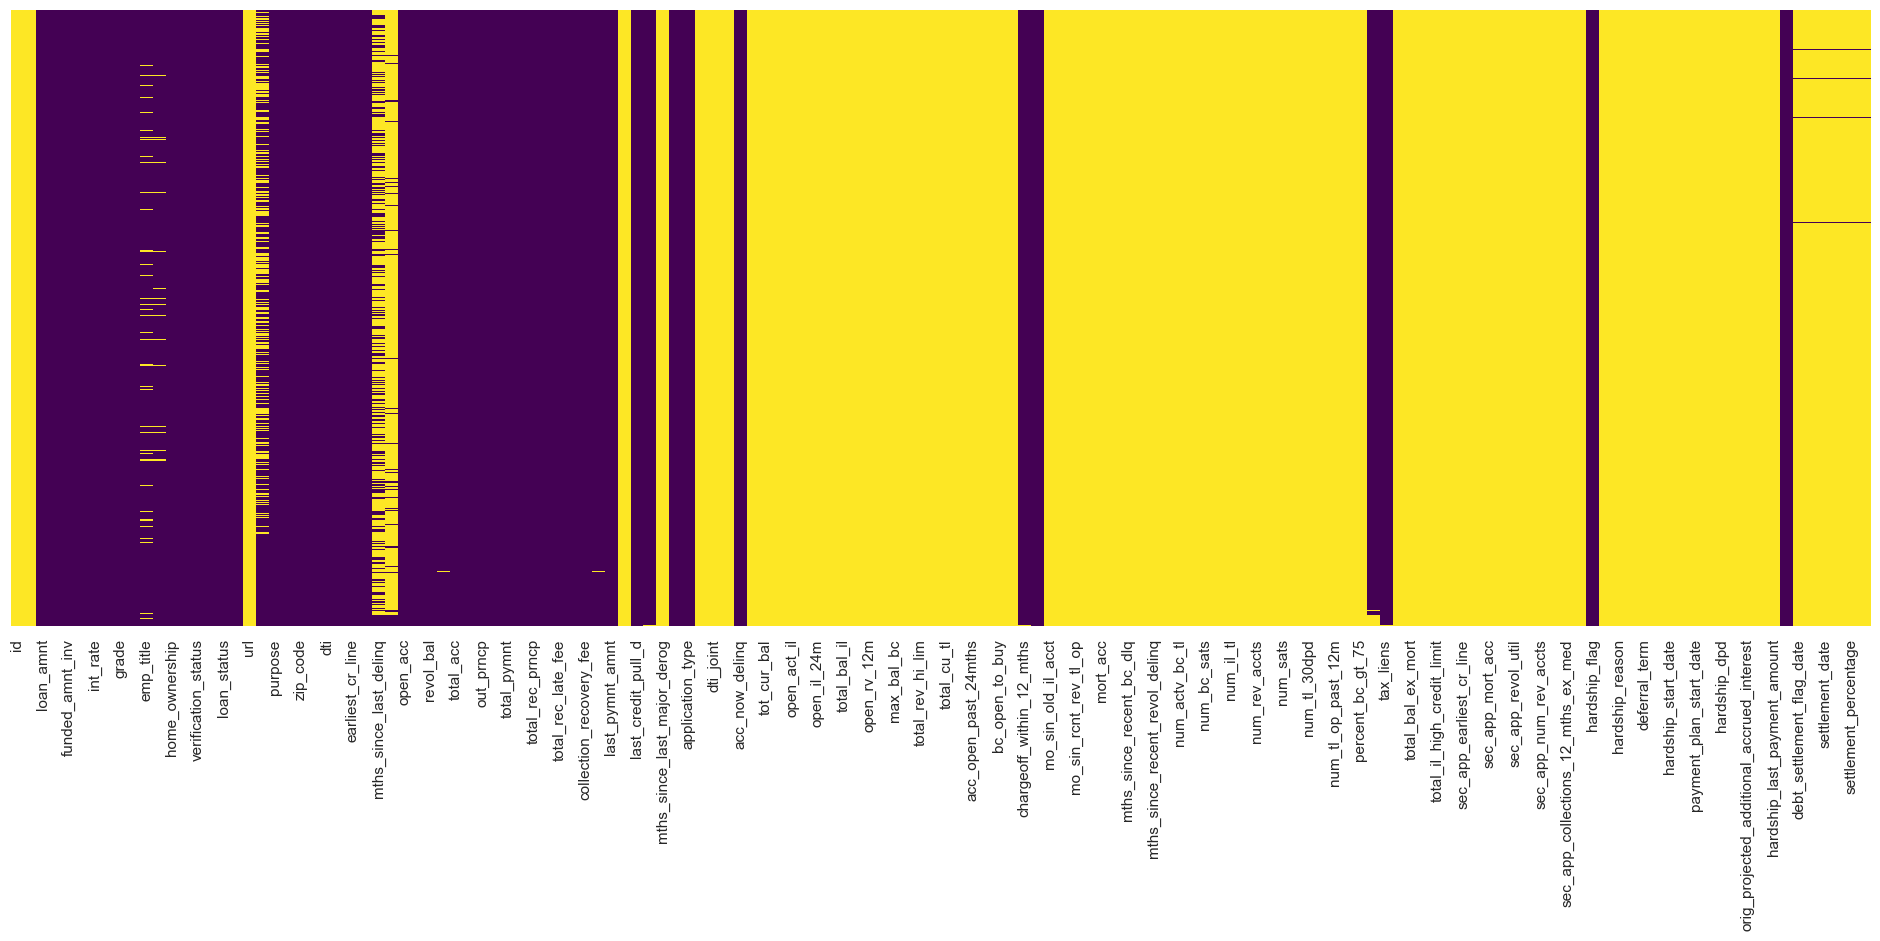

In [6]:
# Check Null values through visualization
sns.set(rc={'figure.figsize':(24,8)})
sns.heatmap(loan_stat_df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

#### There are 90 variables whicha are having more than 90% of missing data which can be removed
#### 1 variable is having more than 60% of misssing data

In [7]:
data_preprocess = DataPreprocess()
drop_variables = data_preprocess.columns_by_missing_percent(df = loan_stat_df, threshold =60)
print(f'Number of columns having most null values = {len(drop_variables)}')

Number of columns having most null values = 91


In [8]:
def drop_columns(df : pd.DataFrame, columns_to_drop : list):
    try:
        df.drop(columns_to_drop, axis = 1, inplace= True)
        return df
        
    except Exception as e:
        raise LoanStatException(e, sys) from e
            
loan_stat_df = drop_columns(df = loan_stat_df, columns_to_drop = drop_variables)
print(f'columns droped = {drop_variables}')

columns droped = ['id', 'member_id', 'url', 'mths_since_last_delinq', 'mths_since_last_record', 'next_pymnt_d', 'mths_since_last_major_derog', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq', 'mths_since_recent_inq', 'mths_since_recent_revol_delinq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_t

<Axes: >

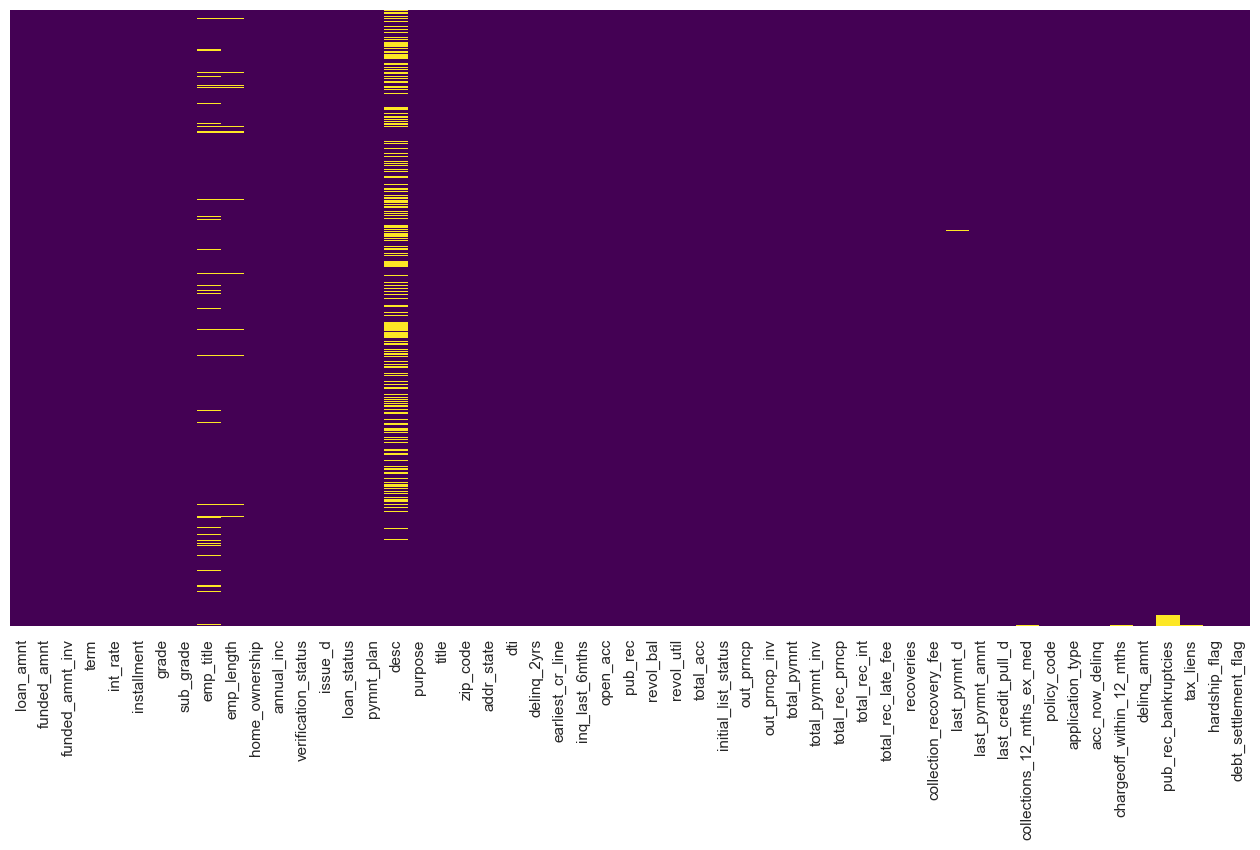

In [9]:
# Check nulls again after removing the null columns
sns.set(rc={'figure.figsize':(16,8)})
sns.heatmap(loan_stat_df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [10]:
# Drop rows which are having null values in all columns
loan_stat_df.dropna(axis=0, how='all',inplace=True)

In [11]:
loan_stat_df.shape

(39786, 53)

In [12]:
loan_stat_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 39786 entries, 0 to 39785
Data columns (total 53 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   loan_amnt                   39786 non-null  float64
 1   funded_amnt                 39786 non-null  float64
 2   funded_amnt_inv             39786 non-null  float64
 3   term                        39786 non-null  object 
 4   int_rate                    39786 non-null  object 
 5   installment                 39786 non-null  float64
 6   grade                       39786 non-null  object 
 7   sub_grade                   39786 non-null  object 
 8   emp_title                   37319 non-null  object 
 9   emp_length                  38708 non-null  object 
 10  home_ownership              39786 non-null  object 
 11  annual_inc                  39786 non-null  float64
 12  verification_status         39786 non-null  object 
 13  issue_d                     39786 no

In [13]:
# Remove Static columns
loan_stat_df = data_preprocess.remove_static_columns(df=loan_stat_df)

In [14]:
# Get list of non numeric columns
non_numeric_cols = data_preprocess.get_non_numeric_columns(df=loan_stat_df)
print("Non Numeric columns")
non_numeric_cols

Non Numeric columns


Index(['term', 'int_rate', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'verification_status', 'issue_d', 'loan_status',
       'desc', 'purpose', 'title', 'zip_code', 'addr_state',
       'earliest_cr_line', 'revol_util', 'last_pymnt_d', 'last_credit_pull_d',
       'debt_settlement_flag'],
      dtype='object')

In [15]:
# Check number of unique values in non numeric columns
for col in non_numeric_cols:
    print(f"Number of unique values in {col}  : {loan_stat_df[col].nunique()}")

Number of unique values in term  : 2
Number of unique values in int_rate  : 371
Number of unique values in grade  : 7
Number of unique values in sub_grade  : 35
Number of unique values in emp_title  : 28862
Number of unique values in emp_length  : 11
Number of unique values in home_ownership  : 5
Number of unique values in verification_status  : 3
Number of unique values in issue_d  : 55
Number of unique values in loan_status  : 2
Number of unique values in desc  : 26568
Number of unique values in purpose  : 14
Number of unique values in title  : 19643
Number of unique values in zip_code  : 823
Number of unique values in addr_state  : 50
Number of unique values in earliest_cr_line  : 526
Number of unique values in revol_util  : 1089
Number of unique values in last_pymnt_d  : 111
Number of unique values in last_credit_pull_d  : 186
Number of unique values in debt_settlement_flag  : 2


#### Q2 : Find the average annual income and number of loan applicants by state

In [16]:
# Average annual income and number of loan applicants are stored in Num_of_Applicants_and_Annual_income_by_states.xlsx

statewise_avg_inc_and_cnt = loan_stat_df[['addr_state','annual_inc']].groupby('addr_state').describe()['annual_inc'][['count','mean']]
statewise_avg_inc_and_cnt = statewise_avg_inc_and_cnt.rename(columns = {'count' : 'Num_of_applicants', 'mean' : 'Average_Income'})
statewise_avg_inc_and_cnt.to_excel("Num_of_Applicants_and_Annual_income_by_states.xlsx", sheet_name = "Sheet1")
statewise_avg_inc_and_cnt.head()

,Num_of_applicants,Average_Income
addr_state,,
AK,81.0,78780.358519
AL,452.0,62690.939071
AR,246.0,59310.730163
AZ,882.0,67318.937324
CA,7105.0,71839.131759


#### Top 5 states which are having highest average income are 
 - NM
 - AK
 - MD
 - DC
 - CT

In [17]:
statewise_avg_inc_and_cnt.sort_values(by="Average_Income", ascending= False).head()

,Num_of_applicants,Average_Income
addr_state,,
NM,190.0,83356.889053
AK,81.0,78780.358519
DC,214.0,77772.504673
MD,1055.0,77731.302720
CT,754.0,75648.113170


#### Top 5 states which are having highest Number of applicants are 
 - CA
 - NY
 - FL
 - TX
 - NJ

In [18]:
statewise_avg_inc_and_cnt.sort_values(by=["Num_of_applicants"], ascending= False).head()

,Num_of_applicants,Average_Income
addr_state,,
CA,7105.0,71839.131759
NY,3817.0,71518.440236
FL,2872.0,64542.537054
TX,2734.0,73531.165468
NJ,1855.0,74770.876410


#### Q3.a Plot a histogram comparing the annual income of applicants from West Virginia and New Mexico


In [19]:
# Filter WV and NM data
df_WV_NM = loan_stat_df[(loan_stat_df['addr_state'] =='WV') | (loan_stat_df['addr_state'] =='NM') ][['addr_state','annual_inc']]

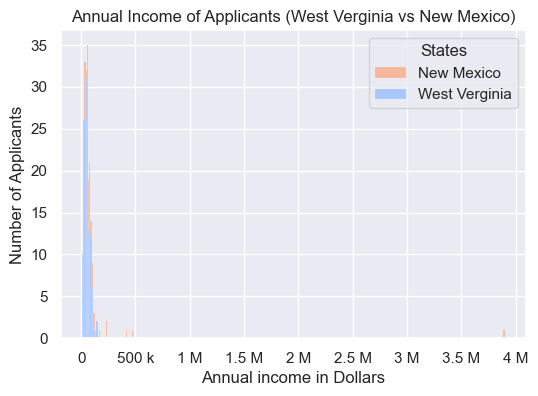

In [20]:
# Plot histogram of annual income for WV and NM
sns.set(rc={'figure.figsize':(6,4)})
fig = sns.histplot(data = df_WV_NM, x='annual_inc', hue='addr_state', palette='coolwarm', alpha=1.0)

fig.xaxis.set_major_formatter(ticker.EngFormatter())

plt.xlabel('Annual income in Dollars')
plt.ylabel('Number of Applicants')
plt.title('Annual Income of Applicants (West Verginia vs New Mexico)')
plt.legend(title='States', labels=['New Mexico', 'West Verginia'])
plt.show(fig)


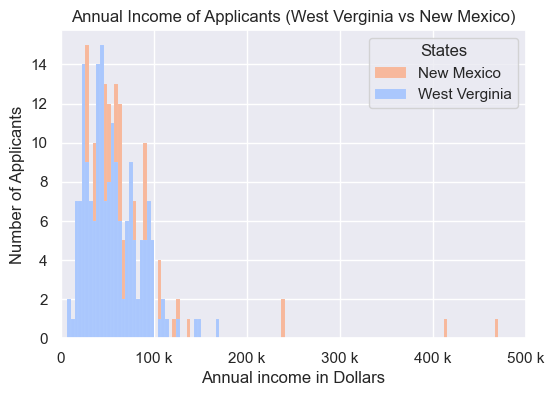

In [21]:
# Plot histogram of annual income for WV and NM restricting annual income to 500K
sns.set(rc={'figure.figsize':(6,4)})
fig = sns.histplot(data = df_WV_NM, x='annual_inc', hue='addr_state', palette='coolwarm', alpha=1.0, bins = 1000)
fig.set(xlim = (0,500000))
fig.xaxis.set_major_formatter(ticker.EngFormatter())

plt.xlabel('Annual income in Dollars')
plt.ylabel('Number of Applicants')
plt.title('Annual Income of Applicants (West Verginia vs New Mexico)')
plt.legend(title='States', labels=['New Mexico', 'West Verginia'])
plt.show(fig)

#### Q3.b Form and test a hypothesis regarding the average annual incomes of the residents of West Virginia and New Mexico.

In [22]:
# Check number of samples in  WV and NM
df_WV = df_WV_NM[df_WV_NM['addr_state']=='WV']['annual_inc']
df_NM = df_WV_NM[df_WV_NM['addr_state']=='NM']['annual_inc']
print(f'Number of samples for WV = {df_WV.shape[0]}')
print(f'Number of samples for NM = {df_NM.shape[0]}')

Number of samples for WV = 177
Number of samples for NM = 190


In [23]:
# Check average annual income of WV and NM
print(f'Average West verginia annual income = {np.mean(df_WV)}')
print(f'Average West verginia annual income = {np.mean(df_NM)}')

Average West verginia annual income = 54940.05062146893
Average West verginia annual income = 83356.88905263158


In [24]:
# import scipy.stats as stats
# sm.qqplot(df_NM.to_numpy(),line='45',fit=True,dist=stats.norm)

In [25]:
# Normality check for NM annual income distribution
utils  = utils()
print('Check Normality for New Mexico')
utils.perform_normality_test(data_array = df_NM.to_numpy())

Check Normality for New Mexico
Statistics=0.116, p=0.000
Sample does not look Gaussian (reject H0)


In [26]:
# import scipy.stats as stats
# sm.qqplot(df_WV.to_numpy(),line='45',fit=True,dist=stats.norm)

In [27]:
# Normality check for WV annual income distribution
print('Check Normality for West Verginia')
utils.perform_normality_test(data_array = df_WV.to_numpy())

Check Normality for West Verginia
Statistics=0.940, p=0.000
Sample does not look Gaussian (reject H0)


In [28]:
# Check median annual income of WV and NM as we dont have normal distribution
print(f'Average West verginia annual income = {np.median(df_WV)}')
print(f'Average West verginia annual income = {np.median(df_NM)}')

Average West verginia annual income = 48500.0
Average West verginia annual income = 53502.0


In [29]:
utils.perform_ttest_ind_samples(sample1 = df_WV.to_numpy(), sample2 = df_NM.to_numpy())

Statistics=-1.330, p=0.184
average annual incomes of the residents of West Virginia and New Mexico have same distribution


In [30]:
# Conducting mannwhitneyu non parametric test for indivial samples since they are not normally distributed
utils.perform_mannwhitneyu(sample1 = df_WV.to_numpy(), sample2 = df_NM.to_numpy())

Statistics=15307.500, p=0.138
average annual incomes of the residents of West Virginia and New Mexico have same distribution


### Encoding

In [31]:
# Performing ordinal encoding for the columns
loan_stat_df = data_preprocess.ordinal_encoding(df = loan_stat_df)

In [32]:
# Data cleanup for int_rate and revo_util
loan_stat_df['int_rate'] = loan_stat_df['int_rate'].str.replace("%","").astype('float64')
loan_stat_df['revol_util'] = loan_stat_df['revol_util'].str.replace("%","").astype('float64')

# Handling date columns
loan_stat_df['issue_d']=  pd.to_datetime(loan_stat_df['issue_d'], infer_datetime_format=True)
loan_stat_df['earliest_cr_line']=  pd.to_datetime(loan_stat_df['earliest_cr_line'], infer_datetime_format=True)
loan_stat_df['credit_hist_days'] = (loan_stat_df['issue_d'] - loan_stat_df['earliest_cr_line']).dt.days

# Remove unwanted columns
rem_cols = ['desc','title','last_pymnt_d','last_credit_pull_d','earliest_cr_line','issue_d','emp_title']
loan_stat_df.drop(rem_cols, axis=1, inplace=True)

In [33]:
# Perform target encoding for 'purpose','zip_code','addr_state'

target_enc_cols = ['purpose','zip_code','addr_state']
loan_stat_df = data_preprocess.target_encoding(df = loan_stat_df, cat_columns = target_enc_cols)

In [34]:
# Check dtaaframe schema after encoding
loan_stat_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 39786 entries, 0 to 39785
Data columns (total 35 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   loan_amnt                39786 non-null  float64
 1   funded_amnt              39786 non-null  float64
 2   funded_amnt_inv          39786 non-null  float64
 3   term                     39786 non-null  int64  
 4   int_rate                 39786 non-null  float64
 5   installment              39786 non-null  float64
 6   grade                    39786 non-null  int32  
 7   sub_grade                39786 non-null  int64  
 8   emp_length               38708 non-null  float64
 9   home_ownership           39786 non-null  int64  
 10  annual_inc               39786 non-null  float64
 11  verification_status      39786 non-null  int64  
 12  loan_status              39786 non-null  int64  
 13  dti                      39786 non-null  float64
 14  delinq_2yrs              39

#### Handling Null values

In [35]:

loan_stat_df.emp_length.fillna(0.0, inplace=True)
loan_stat_df.revol_util.fillna(loan_stat_df.revol_util.mean(), inplace=True)
loan_stat_df.pub_rec_bankruptcies.fillna(0.0, inplace=True)

In [36]:
loan_stat_df.isnull().sum().any()

False

#### Outliers

#### There will be 30% reduction of data if we remove outliers

In [37]:
def outlier_by_zscore(df, outlier_cols, threshold = 3.0):

    total_samples = df.shape[0]
    print(f'No of samples before outlier treatment = {total_samples}')
    for col in outlier_cols:
        col_mean = df[col].mean()
        col_std = df[col].std()
        outlier = df[col][(np.abs(df[col].apply(lambda x : (x - col_mean) /col_std)) > 3)]
        df.drop(outlier.index, inplace=True) 
        print(f'Outliers in column {col} = {outlier.shape}')
    final_samples = df.shape[0]
    print(f'No of samples after outlier treatment = {final_samples}')

lsd = loan_stat_df.copy()
outlier_by_zscore(df = lsd, outlier_cols = lsd.drop('loan_status', axis=1).columns)

No of samples before outlier treatment = 39786
Outliers in column loan_amnt = (719,)
Outliers in column funded_amnt = (97,)
Outliers in column funded_amnt_inv = (300,)
Outliers in column term = (0,)
Outliers in column int_rate = (39,)
Outliers in column installment = (264,)
Outliers in column grade = (215,)
Outliers in column sub_grade = (91,)
Outliers in column emp_length = (0,)
Outliers in column home_ownership = (99,)
Outliers in column annual_inc = (221,)
Outliers in column verification_status = (0,)
Outliers in column dti = (0,)
Outliers in column delinq_2yrs = (930,)
Outliers in column inq_last_6mths = (230,)
Outliers in column open_acc = (284,)
Outliers in column pub_rec = (1973,)
Outliers in column revol_bal = (743,)
Outliers in column revol_util = (0,)
Outliers in column total_acc = (299,)
Outliers in column total_pymnt = (289,)
Outliers in column total_pymnt_inv = (128,)
Outliers in column total_rec_prncp = (32,)
Outliers in column total_rec_int = (746,)
Outliers in column to

#### Correlation

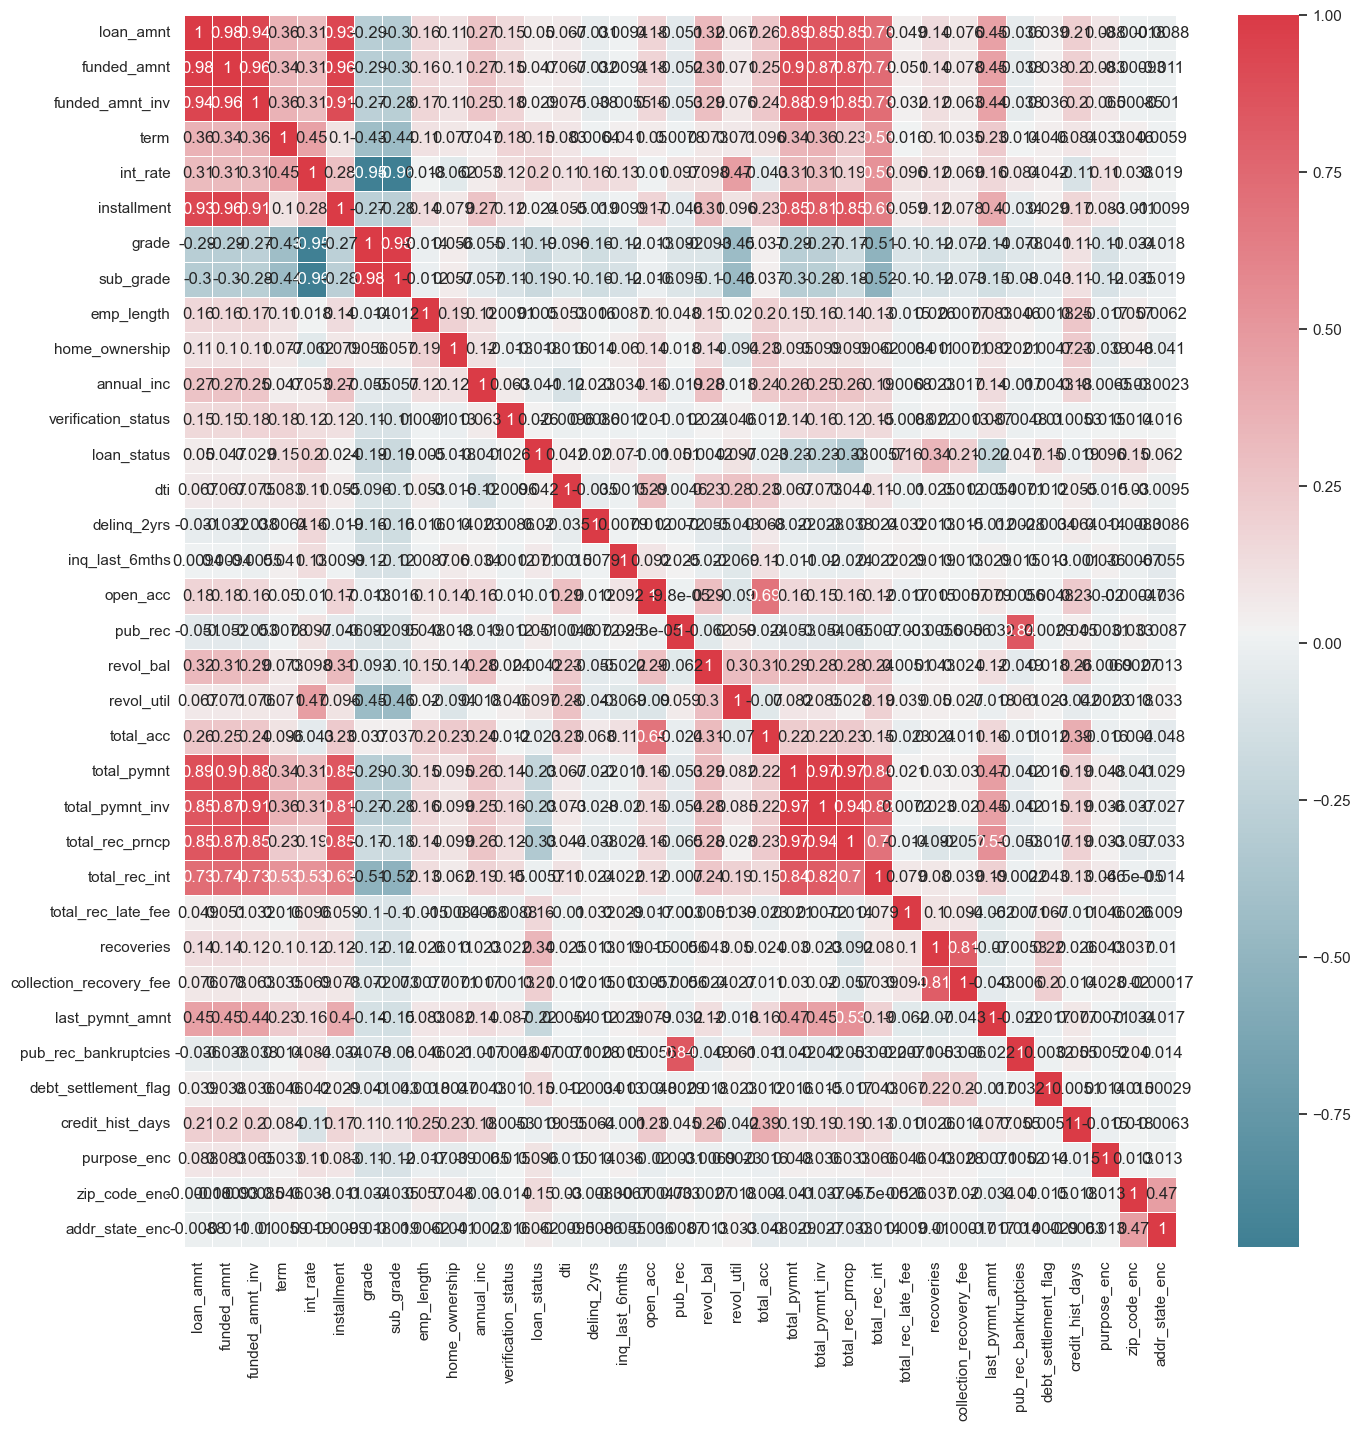

In [38]:
corr = loan_stat_df.corr()
fig, ax = plt.subplots(figsize = (16,16))
sns.heatmap(corr,
            cmap = sns.diverging_palette(220, 10, as_cmap =True),
            annot=True,
            linewidth = .5,
            ax=ax)
fig.show()

In [39]:
# Find columns which are more than 85% correlation
for col in corr.columns:
    corr_cols = corr[(corr.loc[col] >=0.85)][col].to_dict()
    if len(corr_cols)>1:
        del corr_cols[col]
        print(f'correlated columns for {col} : ')
        print('----------------------------------')
        print(corr_cols)
        print('\n')


correlated columns for loan_amnt : 
----------------------------------
{'funded_amnt': 0.9815440238956757, 'funded_amnt_inv': 0.9401797291839464, 'installment': 0.9302092707154803, 'total_pymnt': 0.8854700811912241, 'total_pymnt_inv': 0.8532690634913095, 'total_rec_prncp': 0.8539498942364354}


correlated columns for funded_amnt : 
----------------------------------
{'loan_amnt': 0.9815440238956757, 'funded_amnt_inv': 0.9585856695892186, 'installment': 0.9561080262575063, 'total_pymnt': 0.901906659527031, 'total_pymnt_inv': 0.8696916380251053, 'total_rec_prncp': 0.8721159301123266}


correlated columns for funded_amnt_inv : 
----------------------------------
{'loan_amnt': 0.9401797291839464, 'funded_amnt': 0.9585856695892186, 'installment': 0.9051222063240458, 'total_pymnt': 0.8806043288270176, 'total_pymnt_inv': 0.9118347003545161}


correlated columns for installment : 
----------------------------------
{'loan_amnt': 0.9302092707154803, 'funded_amnt': 0.9561080262575063, 'funded_am

In [40]:
# Removing highly correlated columns
correlated_cols = ['funded_amnt',
                   'funded_amnt_inv',
                   'installment',
                   'total_pymnt',
                   'total_pymnt_inv',
                   'total_rec_prncp',
                   ]

loan_stat_df = drop_columns(df = loan_stat_df, columns_to_drop = correlated_cols)

### Modelling

#### Train test split

In [41]:
X = loan_stat_df.drop(columns = 'loan_status')
y = loan_stat_df['loan_status']

In [42]:
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size = 0.30, random_state=123)

#### Handling imbance classs

#### Performing over sampling since the target class is highly imbalanced

In [43]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))
  

from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 2)
X_train_res, y_train_res = sm.fit_resample(x_train, y_train)
  
print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))
  
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))

Before OverSampling, counts of label '1': 3907
Before OverSampling, counts of label '0': 23943 

After OverSampling, the shape of train_X: (47886, 28)
After OverSampling, the shape of train_y: (47886,) 

After OverSampling, counts of label '1': 23943
After OverSampling, counts of label '0': 23943


#### Hyperparameter and cross validation

In [44]:
space = {
    "n_estimators": hp.choice("n_estimators", [50, 100, 200]),
    "max_depth": scope.int(hp.quniform("max_depth", 5, 10,1)),
    "criterion": hp.choice("criterion", ["gini", "entropy"]),
}

def hyperparameter_tuning(params):
    clf = RandomForestClassifier(**params,n_jobs=-1)
    acc = cross_val_score(clf, X, y,scoring="accuracy", error_score='raise').mean()
    return {"loss": -acc, "status": STATUS_OK}

trials = Trials()

best = fmin(
    fn=hyperparameter_tuning,
    space = space, 
    algo=tpe.suggest, 
    max_evals=100, 
    trials=trials
)

print("Best: {}".format(best))

100%|███████████████████████████████████████████████| 100/100 [23:38<00:00, 14.18s/trial, best loss: -0.9990951647841502]
Best: {'criterion': 0, 'max_depth': 10.0, 'n_estimators': 2}


In [54]:
# Training final model
rand_clf = RandomForestClassifier(n_estimators = 200,criterion='gini', max_depth =10, max_features='sqrt')
rand_clf.fit(X_train_res,y_train_res)

RandomForestClassifier(max_depth=10, n_estimators=200)

In [55]:
y_test.value_counts()

loan_status
0    10173
1     1763
Name: count, dtype: int64

#### Performance metric

In [56]:
rand_clf.score(x_test,y_test)

0.9989946380697051

In [57]:
y_pred = rand_clf.predict(x_test)

accuracy = accuracy_score(y_test,y_pred)
accuracy

0.9989946380697051

In [58]:
conf_mat = confusion_matrix(y_test,y_pred)
conf_mat

array([[10173,     0],
       [   12,  1751]], dtype=int64)

In [59]:


print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('\n clasification report:\n', classification_report(y_test,y_pred))


Accuracy: 0.9989946380697051
F1 score: 0.9965850882185543
Recall: 0.9931934203062961
Precision: 1.0

 clasification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     10173
           1       1.00      0.99      1.00      1763

    accuracy                           1.00     11936
   macro avg       1.00      1.00      1.00     11936
weighted avg       1.00      1.00      1.00     11936



In [60]:
from sklearn.metrics import roc_auc_score, roc_curve
roc_auc_score(y_test, y_pred)

0.9965967101531481

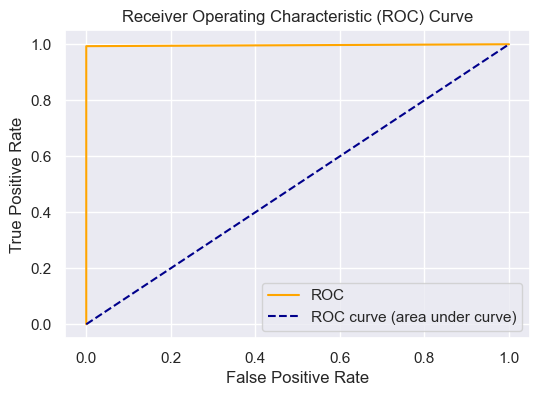

In [61]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--',label='ROC curve (area under curve)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

#### Save Model

In [63]:
import os
import pickle
os.makedirs("model", exist_ok=True)
with open('model/rand_clf.pkl', 'wb') as f:
    pickle.dump(rand_clf, f)

In [64]:
# load model
with open('model/rand_clf.pkl', 'rb') as f:
    loaded_rand_clf = pickle.load(f)

In [65]:
y_pred = loaded_rand_clf.predict(x_test)

accuracy = accuracy_score(y_test,y_pred)
accuracy

0.9989946380697051

In [68]:
# loaded_rand_clf.predict_proba(x_test)